In [1]:
%cd E:\kaggle\iceberg

E:\kaggle\iceberg


In [2]:
import numpy as np
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from os.path import join as opj
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.ndimage.filters import uniform_filter

import sys
batch_size=64
if sys.version_info[1] <= 5:# for my laptop pc, poor gpu memory
    batch_size=32
    from keras.backend.tensorflow_backend import set_session  
    config = tf.ConfigProto()  
    config.gpu_options.allow_growth = True
#     config.gpu_options.per_process_gpu_memory_fraction = 0.9
    set_session(tf.Session(config=config)) 

Using TensorFlow backend.


In [3]:
train = pd.read_json("E:/kaggle/iceberg/train.json/data/processed/train.json")
target_train=train['is_iceberg']
test = pd.read_json("E:/kaggle/iceberg/test.json/data/processed/test.json")

In [4]:
def display_img(band_1, band_2, is_iceberg, angle = None):
    if angle is None:
        title_str = 'Iceberg' if is_iceberg == 1 else 'Ship'
    else:
        title_str = 'Iceberg-' + str(angle) if is_iceberg == 1 else 'Ship-' + str(angle)
    fig = plt.figure(0, figsize=(10,10))
    ax = fig.add_subplot(1,2,1)
    ax.set_title(title_str + ' - Band 1')
    ax.imshow(band_1,cmap='jet')
    ax = fig.add_subplot(1,2,2)
    ax.set_title(title_str + ' - Band 2')
    ax.imshow(band_2,cmap='jet')
    plt.show()

# implement functions to convert SAR data from decibel units to linear units and back again
def decibel_to_linear(band):
     # convert to linear units
    return np.power(10,np.array(band)/10)

def linear_to_decibel(band):
    return 10*np.log10(band)

# implement the Lee Filter for a band in an image already reshaped into the proper dimensions
def lee_filter(band, window, var_noise = 0.25):
    # band: SAR data to be despeckled (already reshaped into image dimensions)
    # window: descpeckling filter window (tuple)
    # default noise variance = 0.25
    # assumes noise mean = 0
    
    mean_window = uniform_filter(band, window)
    mean_sqr_window = uniform_filter(band**2, window)
    var_window = mean_sqr_window - mean_window**2

    weights = var_window / (var_window + var_noise)
    band_filtered = mean_window + weights*(band - mean_window)
    return band_filtered

def apply_lee_filter(band_1_linear, band_2_linear, window_var_index = 0, noise_var_index = 0):
    windows = [2, 4, 8] # can be tuple too if not symetric
    noise_var = np.array([1, 2, 4])
    noise_var_1 = np.round(np.var(band_1_linear) * noise_var, 10)
    noise_var_2 = np.round(np.var(band_2_linear) * noise_var, 10)
    band_1_linear_filtered = lee_filter(band_1_linear, windows[window_var_index], noise_var_1[noise_var_index])
    band_2_linear_filtered = lee_filter(band_2_linear, windows[window_var_index], noise_var_2[noise_var_index])
    return band_1_linear_filtered, band_2_linear_filtered

def apply_lee_filter_single(band_linear, window_var_index = 0, noise_var_index = 0):
    windows = [2, 4, 8] # can be tuple too if not symetric
    noise_var = np.array([1, 2, 4])
    noise_var = np.round(np.var(band_linear) * noise_var, 10)
    band_linear_filtered = lee_filter(band_linear, windows[window_var_index], noise_var[noise_var_index])
    return band_linear_filtered

In [5]:
def np_get_scaled_band(band_list):
    imgs = []
    for band in band_list:        
#         imgs.append((band - band.mean()) / (band.max() - band.min()))
        imgs.append(band - band.mean())
    return np.array(imgs)

def get_more_images(imgs):
    more_images = []
    vert_flip_imgs = []
    hori_flip_imgs = []
    vh_flip_imgs = []
      
    for i in range(0,imgs.shape[0]):
        vert_flip_imgs.append(cv2.flip(imgs[i], 1))
        hori_flip_imgs.append(cv2.flip(imgs[i], 0))
        vh_flip_imgs.append(cv2.flip(imgs[i], -1))
      
    v = np.array(vert_flip_imgs)
    h = np.array(hori_flip_imgs)
    vh = np.array(vh_flip_imgs)
       
    more_images = np.concatenate((imgs,v,h, vh))
    
    return more_images

In [6]:
train_sample = train.sample(10)
train_sample["is_iceberg"]

1374    0
852     1
977     1
1171    1
1371    1
1447    1
1225    0
622     1
212     0
859     1
Name: is_iceberg, dtype: int64

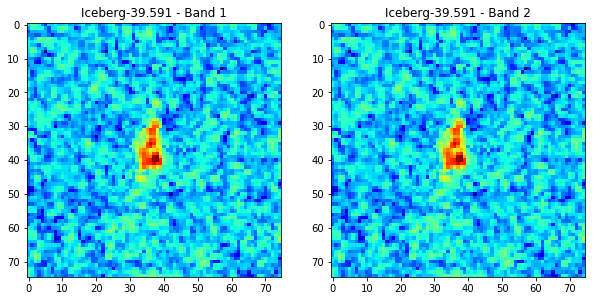

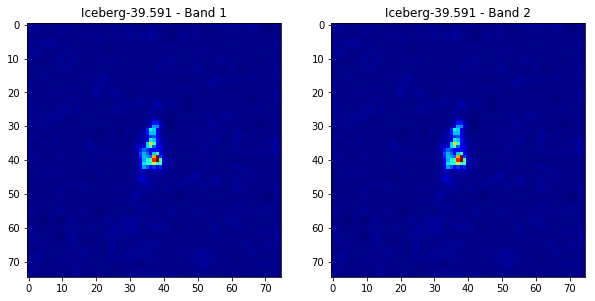

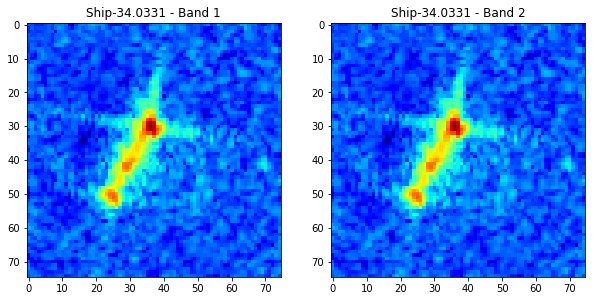

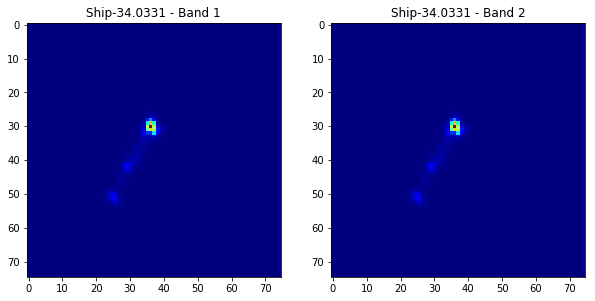

In [7]:
sample_index = 5
band_1, band_2, is_iceberg, angle = np.array(train_sample.iloc[sample_index]["band_1"]).reshape(75, 75), np.array(train_sample.iloc[sample_index]["band_1"]).reshape(75, 75), train_sample.iloc[sample_index]["is_iceberg"], train_sample.iloc[sample_index]["inc_angle"]
display_img(band_1, band_2, is_iceberg, angle)
band_1, band_2 = apply_lee_filter(decibel_to_linear(band_1), decibel_to_linear(band_2))
display_img(band_1, band_2, is_iceberg, angle)

sample_index = 0
band_1, band_2, is_iceberg, angle = np.array(train_sample.iloc[sample_index]["band_1"]).reshape(75, 75), np.array(train_sample.iloc[sample_index]["band_1"]).reshape(75, 75), train_sample.iloc[sample_index]["is_iceberg"], train_sample.iloc[sample_index]["inc_angle"]
display_img(band_1, band_2, is_iceberg, angle)
band_1, band_2 = apply_lee_filter(decibel_to_linear(band_1), decibel_to_linear(band_2))
display_img(band_1, band_2, is_iceberg, angle)

In [8]:
# train['inc_angle']=pd.to_numeric(train['inc_angle'], errors='coerce')#We have only 133 NAs.
# test['inc_angle']=pd.to_numeric(test['inc_angle'], errors='coerce')
# train['inc_angle']=train['inc_angle'].fillna(method='pad')
train["inc_angle"] = train["inc_angle"].replace('na',0)
idx_tr = np.where(train["inc_angle"]>0)
train = train.iloc[idx_tr[0]]
target_train = target_train.iloc[idx_tr[0]]
test['inc_angle']=test['inc_angle'].fillna(method='pad')
X_angle=train['inc_angle']
X_test_angle=test['inc_angle']

In [9]:
#Generate the training data
X_band_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_1"]])
X_band_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_2"]])
#apply filter
X_band_1_filtered = np.array([apply_lee_filter_single(decibel_to_linear(band)) for band in X_band_1])
X_band_2_filtered = np.array([apply_lee_filter_single(decibel_to_linear(band)) for band in X_band_2])
X_band_1_filtered = linear_to_decibel(X_band_1_filtered)
X_band_2_filtered = linear_to_decibel(X_band_2_filtered)
X_band_1 = X_band_1_filtered
X_band_2 = X_band_2_filtered

X_band_3=np.fabs(np.subtract(X_band_1,X_band_2))
X_band_4=np.maximum(X_band_1,X_band_2)
X_band_5=np.minimum(X_band_1,X_band_2)
# subtract mean
X_band_3 = np_get_scaled_band(X_band_3)
X_band_4 = np_get_scaled_band(X_band_4)
X_band_5 = np_get_scaled_band(X_band_5)
    
X_train = np.concatenate([X_band_3[:, :, :, np.newaxis],X_band_4[:, :, :, np.newaxis],X_band_5[:, :, :, np.newaxis]], axis=-1)

X_band_test_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_1"]])
X_band_test_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_2"]])
#apply filter
X_band_test_1_filtered = np.array([apply_lee_filter_single(decibel_to_linear(band)) for band in X_band_test_1])
X_band_test_2_filtered = np.array([apply_lee_filter_single(decibel_to_linear(band)) for band in X_band_test_2])
X_band_test_1_filtered = linear_to_decibel(X_band_test_1_filtered)
X_band_test_2_filtered = linear_to_decibel(X_band_test_2_filtered)
X_band_test_1 = X_band_test_1_filtered
X_band_test_2 = X_band_test_2_filtered

X_band_test_3=np.fabs(np.subtract(X_band_test_1,X_band_test_2))
X_band_test_4=np.maximum(X_band_test_1,X_band_test_2)
X_band_test_5=np.minimum(X_band_test_1,X_band_test_2)
# subtract mean
X_band_test_3 = np_get_scaled_band(X_band_test_3)
X_band_test_4 = np_get_scaled_band(X_band_test_4)
X_band_test_5 = np_get_scaled_band(X_band_test_5)
    
X_test = np.concatenate([X_band_test_3[:, :, :, np.newaxis], X_band_test_4[:, :, :, np.newaxis],X_band_test_5[:, :, :, np.newaxis]],axis=-1)

In [10]:
X_train = get_more_images(X_train)
target_train = np.concatenate((target_train, target_train, target_train, target_train))
X_angle = np.concatenate((X_angle, X_angle, X_angle, X_angle))

In [11]:
print(X_train.shape, target_train.shape, X_angle.shape, X_test.shape)

(5884, 75, 75, 3) (5884,) (5884,) (8424, 75, 75, 3)


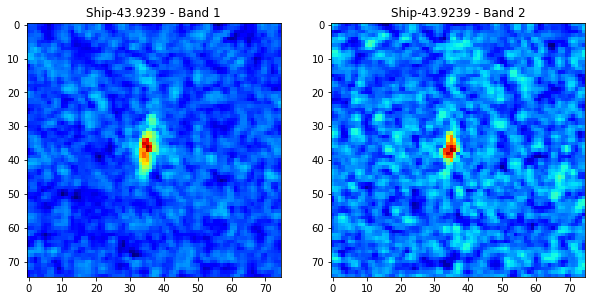

In [12]:
display_img(X_band_1[0], X_band_2[0], target_train[0], X_angle[0])

In [13]:
# use_custom_augmentation = True
# if use_custom_augmentation:
#     df_train = pd.read_json('E:/kaggle/iceberg/train.json/data/processed/train.json')
#     df_test = pd.read_json('E:/kaggle/iceberg/test.json/data/processed/test.json')
#     Xtrain = get_scaled_imgs(df_train)
#     Xtest = get_scaled_imgs(df_test)
#     Ytrain = np.array(df_train['is_iceberg'])
    
#     df_train["inc_angle"] = pd.to_numeric(df_train["inc_angle"], errors='coerce')
#     df_test["inc_angle"] =  pd.to_numeric(df_test["inc_angle"], errors='coerce')
#     df_train['inc_angle']=df_train['inc_angle'].fillna(method='pad')
#     df_test['inc_angle']=df_test['inc_angle'].fillna(method='pad')
#     df_train["inc_angle"] = df_train["inc_angle"].replace('na',0)
#     df_test["inc_angle"] = df_test["inc_angle"].replace('na',0)
#     idx_tr = np.where(df_train["inc_angle"]>0)
#     Xtrain = Xtrain[idx_tr[0]]
#     Ytrain = Ytrain[idx_tr[0]]
    
#     Xtrain_angle = np.array(df_train["inc_angle"])[idx_tr[0]]
#     Xtest_angle = df_test['inc_angle']
    
#     Xtrain = get_more_images(Xtrain) 
#     Ytrain = np.concatenate((Ytrain,Ytrain,Ytrain, Ytrain))
    
#     Xtrain_angle = np.concatenate((Xtrain_angle, Xtrain_angle, Xtrain_angle, Xtrain_angle))

In [14]:
# X_train = Xtrain
# target_train = Ytrain
# X_test = Xtest
# X_angle = Xtrain_angle
# X_test_angle = Xtest_angle
# test = df_test

In [22]:
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, Activation
from keras.layers import *
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras import initializers
from keras.optimizers import Adam
from keras.optimizers import rmsprop
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

from keras.datasets import cifar10
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16
from keras.applications.xception import Xception
from keras.applications.mobilenet import MobileNet
from keras.applications.vgg19 import VGG19
from keras.layers import Concatenate, Dense, LSTM, Input, concatenate
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

#Data Aug for multi-input
from keras.preprocessing.image import ImageDataGenerator

In [27]:
def getSimpleCnnModel(input_tensor=None, angle_input = None):
    #Build keras model
    if angle_input is None:
        angle_input = Input(shape=[1], name="angle")
    angle_layer = Dense(1)(angle_input)
    if input_tensor is None:
        img_input = Input(shape=Xtrain.shape[1:], name="img")
    else:
        img_input = input_tensor
    
    # CNN 1
    x = Conv2D(64, kernel_size=(3, 3), activation='relu')(img_input)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)
    x = Dropout(0.2)(x)

    # CNN 2
    x = Conv2D(128, kernel_size=(3, 3), activation='relu' )(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = Dropout(0.2)(x)

    # CNN 3
    x = Conv2D(128, kernel_size=(3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = Dropout(0.3)(x)

    #CNN 4
    x = Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = Dropout(0.3)(x)

    # You must flatten the data for the dense layers
    x = Flatten()(x)

    #Dense 1
    fc = Dense(512, activation='relu')(x)
    fc = Dropout(0.2)(fc)

    #Dense 2
    fc = Dense(256, activation='relu', name='final')(fc)
    fc = Dropout(0.2)(fc)
    
    #angle fuse
    fc = Concatenate()([fc, angle_layer])
                     
    # Output 
    predictions = Dense(1, activation="sigmoid")(fc)
    
    model = Model(inputs=[img_input, angle_input], outputs=predictions)
                     
    optimizer = Adam(lr=1e-3, decay=0.0)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model

In [30]:
# Define the image transformations here
gen = ImageDataGenerator(horizontal_flip = False,
                         vertical_flip = False,
                         width_shift_range = 0.,
                         height_shift_range = 0.,
                         channel_shift_range=0,
                         zoom_range = 0.5,
                         rotation_range = 10)

# Here is the function that merges our two generators
# We use the exact same generator with the same random seed for both the y and angle arrays
def gen_flow_for_two_inputs(X1, X2, y):
    genX1 = gen.flow(X1,y,  batch_size=batch_size,seed=55)
    genX2 = gen.flow(X1,X2, batch_size=batch_size,seed=55)
    while True:
            X1i = genX1.next()
            X2i = genX2.next()
            #Assert arrays are equal - this was for peace of mind, but slows down training
            #np.testing.assert_array_equal(X1i[0],X2i[0])
            yield [X1i[0], X2i[1]], X1i[1]

# Finally create generator
def get_callbacks(filepath, patience=2):
   #es = EarlyStopping('val_loss', patience=10, mode="min")
    es = EarlyStopping('val_loss', patience=20, mode="min")
    reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1, epsilon=1e-4, mode='min')
    msave = ModelCheckpoint(filepath, save_best_only=True)
    return [es, msave, reduce_lr_loss]

def getVggAngleModel():
    input_2 = Input(shape=[1], name="angle")
    angle_layer = Dense(1, )(input_2)
    base_model = VGG16(weights='imagenet', include_top=False, 
                 input_shape=X_train.shape[1:], classes=1)
    x = base_model.get_layer('block5_pool').output
    x = GlobalMaxPooling2D()(x)
    base_model2 = keras.applications.mobilenet.MobileNet(weights=None, alpha=0.9,input_tensor = base_model.input,include_top=False, input_shape=X_train.shape[1:])
    x2 = base_model2.output
    x2 = GlobalAveragePooling2D()(x2)
    
    base_model3 = getSimpleCnnModel(input_tensor=base_model.input, angle_input=input_2)
    x3 = base_model3.get_layer('final').output

    merge_one = concatenate([x, x2, x3, angle_layer])

    merge_one = Dropout(0.6)(merge_one)
    predictions = Dense(1, activation='sigmoid',kernel_initializer='he_normal')(merge_one)
    
    model = Model(inputs=[base_model.input, input_2], outputs=predictions)
    
    sgd = Adam(lr=1e-4) #SGD(lr=1e-4, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='binary_crossentropy',
                  optimizer=sgd,
                  metrics=['accuracy'])
    return model


#Using K-fold Cross Validation with Data Augmentation.
def myAngleCV(X_train, X_angle, X_test):
    K=3
    folds = list(StratifiedKFold(n_splits=K, shuffle=True, random_state=16).split(X_train, target_train))
    y_test_pred_log = 0
    y_train_pred_log=0
    y_valid_pred_log = 0.0*target_train
    for j, (train_idx, test_idx) in enumerate(folds):
        print('\n===================FOLD=',j)
        X_train_cv = X_train[train_idx]
        y_train_cv = target_train[train_idx]
        X_holdout = X_train[test_idx]
        Y_holdout= target_train[test_idx]
        
        #Angle
        X_angle_cv=X_angle[train_idx]
        X_angle_hold=X_angle[test_idx]

        #define file path and get callbacks
        file_path = "%s_vgg_mobile_weights.hdf5"%j
        callbacks = get_callbacks(filepath=file_path, patience=10)
        gen_flow = gen_flow_for_two_inputs(X_train_cv, X_angle_cv, y_train_cv)
        galaxyModel= getVggAngleModel()
        galaxyModel.fit_generator(
                gen_flow,
                steps_per_epoch=np.ceil(len(X_train_cv) / batch_size),
                epochs=100,
                shuffle=True,
                verbose=1,
                validation_data=([X_holdout,X_angle_hold], Y_holdout),
                callbacks=callbacks)

        #Getting the Best Model
        galaxyModel.load_weights(filepath=file_path)
        #Getting Training Score
        score = galaxyModel.evaluate([X_train_cv,X_angle_cv], y_train_cv, verbose=0)
        print('Train loss:', score[0])
        print('Train accuracy:', score[1])
        #Getting Test Score
        score = galaxyModel.evaluate([X_holdout,X_angle_hold], Y_holdout, verbose=0)
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])

        #Getting validation Score.
        pred_valid=galaxyModel.predict([X_holdout,X_angle_hold])
        y_valid_pred_log[test_idx] = pred_valid.reshape(pred_valid.shape[0])

        #Getting Test Scores
        temp_test=galaxyModel.predict([X_test, X_test_angle])
        y_test_pred_log+=temp_test.reshape(temp_test.shape[0])

        #Getting Train Scores
        temp_train=galaxyModel.predict([X_train, X_angle])
        y_train_pred_log+=temp_train.reshape(temp_train.shape[0])

    y_test_pred_log=y_test_pred_log/K
    y_train_pred_log=y_train_pred_log/K

    print('\n Train Log Loss Validation= ',log_loss(target_train, y_train_pred_log))
    print(' Test Log Loss Validation= ',log_loss(target_train, y_valid_pred_log))
    return y_test_pred_log

In [31]:
preds=myAngleCV(X_train, X_angle, X_test)


===================FOLD= 0
Epoch 1/100
62/62 [==============================] - 74s - loss: 0.5677 - acc: 0.7496 - val_loss: 0.3495 - val_acc: 0.8119
Epoch 2/100
62/62 [==============================] - 23s - loss: 0.4069 - acc: 0.8222 - val_loss: 0.2323 - val_acc: 0.8996
Epoch 3/100
62/62 [==============================] - 22s - loss: 0.3654 - acc: 0.8411 - val_loss: 0.2168 - val_acc: 0.9057
Epoch 4/100
62/62 [==============================] - 23s - loss: 0.2769 - acc: 0.8760 - val_loss: 0.2114 - val_acc: 0.9103
Epoch 5/100
62/62 [==============================] - 23s - loss: 0.2374 - acc: 0.8995 - val_loss: 0.1799 - val_acc: 0.9266
Epoch 6/100
62/62 [==============================] - 20s - loss: 0.2351 - acc: 0.9024 - val_loss: 0.2095 - val_acc: 0.9174
Epoch 7/100
62/62 [==============================] - 20s - loss: 0.2342 - acc: 0.9018 - val_loss: 0.1942 - val_acc: 0.9179
Epoch 8/100
62/62 [==============================] - 22s - loss: 0.2006 - acc: 0.9192 - val_loss: 0.1592 - val_

62/62 [==============================] - 22s - loss: 0.1836 - acc: 0.9311 - val_loss: 0.1564 - val_acc: 0.9393
Epoch 14/100
62/62 [==============================] - 20s - loss: 0.1641 - acc: 0.9327 - val_loss: 0.2005 - val_acc: 0.9332
Epoch 15/100
62/62 [==============================] - 20s - loss: 0.1668 - acc: 0.9296 - val_loss: 0.1595 - val_acc: 0.9347
Epoch 16/100
62/62 [==============================] - 21s - loss: 0.1643 - acc: 0.9317 - val_loss: 0.1610 - val_acc: 0.9378
Epoch 17/100
62/62 [==============================] - 21s - loss: 0.1451 - acc: 0.9392 - val_loss: 0.1610 - val_acc: 0.9388
Epoch 18/100
62/62 [==============================] - 21s - loss: 0.1365 - acc: 0.9439 - val_loss: 0.1577 - val_acc: 0.9449
Epoch 19/100
62/62 [==============================] - 21s - loss: 0.1365 - acc: 0.9477 - val_loss: 0.1915 - val_acc: 0.9337
Epoch 20/100
62/62 [==============================] - 21s - loss: 0.1575 - acc: 0.9359 - val_loss: 0.1615 - val_acc: 0.9383
Epoch 21/100
62/62 [=

62/62 [==============================] - 21s - loss: 0.0586 - acc: 0.9781 - val_loss: 0.1888 - val_acc: 0.9444
Epoch 27/100
62/62 [==============================] - 21s - loss: 0.0515 - acc: 0.9819 - val_loss: 0.1951 - val_acc: 0.9434
Epoch 28/100
62/62 [==============================] - 21s - loss: 0.0504 - acc: 0.9813 - val_loss: 0.2057 - val_acc: 0.9398
Epoch 29/100
62/62 [==============================] - 21s - loss: 0.0476 - acc: 0.9829 - val_loss: 0.2073 - val_acc: 0.9388
Epoch 30/100
62/62 [==============================] - 21s - loss: 0.0408 - acc: 0.9869 - val_loss: 0.2248 - val_acc: 0.9419
Epoch 31/100
62/62 [==============================] - 21s - loss: 0.0396 - acc: 0.9834 - val_loss: 0.2146 - val_acc: 0.9444
Epoch 32/100
62/62 [==============================] - 21s - loss: 0.0484 - acc: 0.9814 - val_loss: 0.2107 - val_acc: 0.9454
Epoch 33/100
62/62 [==============================] - 21s - loss: 0.0423 - acc: 0.9839 - val_loss: 0.2158 - val_acc: 0.9444
Epoch 34/100
61/62 [=

D:\Miniconda3\lib\site-packages\sklearn\metrics\classification.py:1694: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
D:\Miniconda3\lib\site-packages\sklearn\metrics\classification.py:1694: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)


In [32]:
#Submission for each day.
submission = pd.DataFrame()
submission['id']=test['id']
submission['is_iceberg']=preds
submission.to_csv('submission-vgg-mobilenet-plain.csv', index=False)